In [39]:
import local_seqtools.general_utils as tools
import pandas as pd
import numpy as np
import local_conservation_analysis_pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align

import matplotlib.pyplot as plt
plt.style.use('custom_standard')
# plt.style.use('custom_small')
import seaborn as sns
# pd.options.plotting.backend = "plotly"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# import score tables

In [40]:
score_key_file = '../../benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_scores_v3/score_key.csv'
score_key = pd.read_csv(score_key_file)
colmap = {
    'aln_property_entropy': 'property_entropy',
    'aln_shannon_entropy': 'shannon_entropy'
}
for i, row in score_key.iterrows():
    if row['score_key'] in colmap:
        score_key.at[i, 'columnwise_score_function_name'] = colmap[row['score_key']]

score_key = score_key.fillna('MSA')

def get_num_passing(table_file, score_key='hit_z_scores'):
    df = pd.read_csv(table_file)
    return (~df[score_key].isna()).sum()

score_key['num_passing'] = score_key['table_file'].apply(get_num_passing)

In [41]:
score_key.head(10)

,score_index,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing
0,0.0,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2362
1,1.0,MSA - MAFFT,Tetrapoda,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2362
2,2.0,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2524
3,3.0,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2524
4,4.0,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2343
5,5.0,MSA - MAFFT,Metazoa,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2343
6,6.0,MSA - MAFFT,Eukaryota,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2110
7,7.0,MSA - MAFFT,Eukaryota,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2110
8,8.0,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,shannon_entropy,1.0,2445
9,9.0,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,shannon_entropy,1.0,2541


# filtering down to the scores that I'm analyzing

## removing Euakryota 
Too many sequences get removed from the Eukaryota level when using MSA (because of the number of gaps in the alignment), so I will remove the eukaryota level from the Alignment.
Note that the scores of both methods drop when going from Metazoa to Euakryota, but the pairwise still performs better than the MSA.

In [42]:
score_key_filt = score_key[score_key['level']!='Eukaryota'].copy()

## removing similarity threshold = 0.5
We don't end up using this variant of the method in the final analysis and I think it might be a biased approach anyway.
It might be removed from the entire tool

In [43]:
score_key_filt=score_key_filt[score_key_filt['similarity_threshold']!=0.5]

## removing shannon entropy

In [44]:
score_key_filt=score_key_filt[score_key_filt['columnwise_score_function_name']=='property_entropy']

## remove alternate matrices and more unusual flank sizes

In [45]:
score_key_filt=score_key_filt[~score_key_filt['score_key'].isin(['fragpair_gapless_lf2_rf2_edssmat50', 'fragpair_gapless_lf5_rf5_blosum62', 'fragpair_gapless_lf10_rf10_edssmat50'])]

In [46]:
score_key_filt

,score_index,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing
0,0.0,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2362
2,2.0,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2524
4,4.0,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2343
10,10.0,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,property_entropy,1.0,2445
11,11.0,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,property_entropy,1.0,2541
14,14.0,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2448
15,15.0,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2544
21,21.0,Pairwise,Vertebrata,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,property_entropy,1.0,2602
25,25.0,Pairwise,Vertebrata,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,property_entropy,1.0,2703
31,31.0,Pairwise,Vertebrata,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2605


# get scores

Set score_index as the dataframe index

In [47]:
# check if the column contains duplicates
# assert ~score_key_filt['score_index'].duplicated(keep=False).any(), 'There are duplicate score indexes'
score_key_filt=score_key_filt.set_index('score_index', drop=True, verify_integrity=True) # verify_integrity checks for duplicates already

## import and merge scores into 1 table

In [48]:
def import_score_table(score_index_df, score_index):
    table_file = score_index_df.loc[score_index, 'table_file']
    return pd.read_csv(table_file)

def import_multiple_scores(score_index_df, score_index_list, score_colname='hit_z_scores'):
    df = import_score_table(score_index_df, score_index_list[0])
    df=df[
        [
            'reference_index',
            'ELM_motif_class',
            'verified interaction',
            'regex',
            'UniprotID',
            'name',
            'gene_id',
            'hit end position',
            'hit start position',
            'hit_sequence',
            'json_file',
            score_colname,
        ]
    ]
    df = df.rename(columns={score_colname: score_index_list[0]})
    for score_index in score_index_list[1:]:
        df2 = import_score_table(score_index_df, score_index)
        df2 = df2[['reference_index', score_colname]]
        df2 = df2.rename(columns={score_colname: score_index})
        df = pd.merge(df, df2, on='reference_index', how='outer')
    return df

In [49]:
score_indexes = list(score_key_filt.index)
zscores = import_multiple_scores(score_key_filt, score_indexes)

## remove any entries that don't have valid values for all of the scores

In [50]:
l = len(zscores)
print('require all benchmark entries to have all MSA entries')
zscores=zscores.dropna(subset=score_key_filt[score_key_filt['aln_type']=='MSA - MAFFT'].index).copy()
print(f'dropped {l-len(zscores)} entries')

require all benchmark entries to have all MSA entries
dropped 704 entries


In [51]:
# zscores['num_passing'] = zscores[score_indexes].count(axis=1)
# zscores['num_passing'].value_counts()
# for each row, get a list of the score columns that are not nan
# zscores['passing_scores'] = zscores[score_indexes].apply(lambda x: list(x.dropna().index), axis=1)
zscores[score_indexes].apply(lambda x: list(x.dropna().index), axis=1).value_counts()

[0.0, 2.0, 4.0, 10.0, 11.0, 14.0, 15.0, 21.0, 25.0, 31.0, 35.0, 38.0, 39.0, 42.0, 43.0, 58.0, 59.0, 66.0, 67.0, 74.0, 75.0]    2128
[0.0, 2.0, 4.0, 11.0, 15.0, 25.0, 35.0, 39.0, 43.0, 59.0, 67.0, 75.0]                                                            25
[0.0, 2.0, 4.0, 14.0, 15.0, 31.0, 35.0, 42.0, 43.0, 58.0, 59.0, 66.0, 67.0, 74.0, 75.0]                                           1
[0.0, 2.0, 4.0, 10.0, 14.0, 15.0, 21.0, 31.0, 35.0, 38.0, 39.0, 42.0, 43.0, 58.0, 59.0, 66.0, 67.0, 74.0, 75.0]                   1
Name: count, dtype: int64

In [52]:
print('require all benchmark entries to have the other scores\n will drop:')
print(f'{zscores[score_indexes].isna().any(axis=1).sum()} entries')
zscores=zscores.dropna(subset=score_indexes).copy()
print(f'dropped {l-len(zscores)} entries total')

require all benchmark entries to have the other scores
 will drop:
27 entries
dropped 731 entries total


In [53]:
temp = zscores[zscores['ELM_motif_class']=='LIG_14-3-3_CanoR_1'].copy()
temp['hit_length'] = temp['hit_sequence'].apply(len)
# temp['hit_length'].value_counts()
# temp['hit_length'].value_counts().sort_index().plot(kind='bar')

convert the score lists to lists (they are strings here)

In [54]:
from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

## add the kibby scores to the table
see `../../src/data_processing/BENCHMARK_processing/p5_kibby_conservation/`

In [55]:
def kibby_score_str_2_list(s):
    return np.array([float(x) for x in s.split(' ')])

In [56]:
kibby_score_file = '../../benchmark/benchmark_v3/kibby_scores/gene_seqs_kibby_scores.csv'
kibby_df = pd.read_csv(kibby_score_file)
kibby_df['gene_id'] = kibby_df['header'].apply(lambda x: x.split('\t')[0])
kibby_df.conservation = kibby_df.conservation.apply(kibby_score_str_2_list)
kibby_df=kibby_df.drop(columns=['header'])
kibby_df

,sequence,conservation,gene_id
0,MADIKTGIFAKNVQKRLNRAQEKVLQKLGKADETKDEQFEEYVQNF...,"[0.6059, 0.4469, 0.4653, 0.424, 0.5766, 0.4635...",10116_0:004cdf
1,MSGQTLTDRIAAAQYSVTGSAVARAVCKATTHEVMGPKKKHLDYLI...,"[0.4205, 0.2409, 0.12, 0.229, 0.1935, 0.2742, ...",10116_0:002e5e
2,MSNEVETSATNGQPDQQAAPKAPSKKEKKKGPEKTDEYLLARFKGD...,"[0.5946, 0.4162, 0.3126, 0.2569, 0.2155, 0.182...",9606_0:0016b2
3,MAAPLIPLSQQIPTGNSLYESYYKQVDPAYTGRVGASEAALFLKKS...,"[0.4822, 0.3428, 0.1583, 0.4239, 0.153, 0.1308...",9606_0:0044a5
4,MSTSSLRRQMKNIVHNYSEAEIKVREATSNDPWGPSSSLMSEIADL...,"[0.4792, 0.3475, 0.228, 0.2746, 0.2352, 0.3246...",10116_0:0002b6
...,...,...,...
2158,MLQGPRALASAAGQTPKVVPAMSPTELWPSGLSSPQLCPATATYYT...,"[0.5321, 0.3527, 0.4463, 0.4464, 0.4981, 0.446...",9606_0:00055f
2159,MAASMARGGVSARVLLQAARGTWWNRPGGTSGSGEGVALGTTRKFQ...,"[0.5897, 0.4115, 0.2947, 0.2793, 0.3823, 0.291...",9606_0:0046a5
2160,MNGVLIPHTPIAVDFWSLRRAGTARLFFLSHMHSDHTVGLSSTWAR...,"[0.6346, 0.6527, 0.6132, 0.2277, 0.3778, 0.478...",9606_0:000204
2161,MLPCKKRRTTVTESLQHKGNQEENNVDLESAVKPESDQVKDLSSVS...,"[0.6414, 0.432, 0.5478, 0.5057, 0.6362, 0.4819...",9606_0:00057e


Merge with zscores

In [57]:
zscores=pd.merge(zscores, kibby_df, on='gene_id', how='left')

In [58]:
zscores.head(1)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,...,42.0,43.0,58.0,59.0,66.0,67.0,74.0,75.0,sequence,conservation
0,0,LIG_AP2alpha_2,True,DP[FW],O08838,NaN,10116_0:004cdf,358,356,DPF,...,"[1.2646695131128232, -0.6230319877472846, 0.10...","[-0.232094903715352, -1.3636313814313115, 0.14...","[1.2696047329745765, 1.2696046696975787, 1.269...","[1.0471753033419202, 1.0471752261198142, 1.047...","[1.7222277382800255, 0.38123116719586625, 1.61...","[1.3524714755264853, -0.29264498028111596, 1.2...","[1.6172378689382068, -0.004036543445312039, -0...","[0.23105930001338953, -0.3787416170327342, -0....",MADIKTGIFAKNVQKRLNRAQEKVLQKLGKADETKDEQFEEYVQNF...,"[0.6059, 0.4469, 0.4653, 0.424, 0.5766, 0.4635..."


import the json to get the idr coordinates to calculate a z-score. Note that there are not gaps so no masking is needed.<br>

In [59]:
def extract_hit(s: pd.Series, colname: str):
    st = s['hit start position']
    end = s['hit end position']
    hit = s[colname][st:end+1]
    return hit

# def json_2_idr_positions(json_file):
#     og = group_tools.ConserGene(json_file)
#     return og.idr_start, og.idr_end

check that the hits are the same

In [60]:
zscores['hit2'] = zscores.apply(extract_hit, args=['sequence'], axis=1)
# zscores['kibby_hit_scores'] = zscores.apply(extract_hit, args=['conservation'], axis=1) # these aren't the z-scores
assert (zscores['hit2'] == zscores['hit_sequence']).all(), 'hit sequences from kibby are not all the same as the hit seqs in the table'

In [61]:
def get_kibby_zscores(json_file, scores):
    og = group_tools.ConserGene(json_file)
    assert len(scores) == len(og.query_sequence)
    idr_scores=scores[og.idr_start:og.idr_end+1]
    assert len(idr_scores)==len(og.query_idr_sequence)
    z_scores=tools.z_score_comparison(scores, idr_scores)
    return z_scores

In [62]:
zscores['kibby_zscores'] = zscores.apply(lambda x: get_kibby_zscores(x['json_file'], x['conservation']), axis=1)
zscores['kibby_hit_zscores'] = zscores.apply(extract_hit, args=['kibby_zscores'], axis=1)
zscores=zscores.drop(columns=['hit2', 'sequence', 'conservation', 'kibby_zscores'])
score_indexes.append('kibby_hit_zscores')

## get 1 score for each method for each entry (average score of defined positions in SLiM; except 14-3-3)

Generate "weights" of all 1's for the 14-3-3 SLiM b/c the regex is variable length

In [63]:
zscores['hit_length'] = zscores['hit_sequence'].apply(len)
temp = zscores[zscores['ELM_motif_class']=='LIG_14-3-3_CanoR_1'].copy()
l14_weights = {}
for l in temp['hit_length'].unique():
    l14_weights[l] = np.array([1.0]*l)

In [64]:
position_weights = {
    "DOC_WW_Pin1_4": np.array([0, 0, 0, 1, 1, 0]),  # ...([ST])P.
    "LIG_AP2alpha_2": np.array([1, 1, 1]),  # DP[FW]
    "LIG_EH_1": np.array([0, 1, 1, 1, 0]),  # .NPF.
    "LIG_SH2_GRB2like": np.array([1, 1, 1, 0]),  # (Y)([EDST]|[MLIVAFYHQW])N.
    "LIG_SH3_CIN85_PxpxPR_1": np.array([1, 0, 1, 0, 1, 1]),  # P.[AP].PR
    "enah_LPPPP_FPPPP": np.array([1, 1, 0, 1, 1]),  # [FWYL]P.[AFILTVYWP]P
    "TRAF6": np.array([0,0,0,1,0,1,0,0,1]) # ...P.E..[FYWDE]
}# could use this for a weighted average score

Melt the dataframe

In [65]:
id_cols = [
    'reference_index',
    'ELM_motif_class',
    'verified interaction',
    'regex',
    'UniprotID',
    'name',
    'gene_id',
    'hit end position',
    'hit start position',
    'hit_sequence',
    'json_file',
    'hit_length',
]
z_long = zscores.melt(id_vars=id_cols, value_vars=score_indexes, var_name='score_index', value_name='z_scores')
z_long['mask_array'] = z_long.apply(lambda x: position_weights[x['ELM_motif_class']] if x['ELM_motif_class'] in position_weights else l14_weights[x['hit_length']], axis=1)

In [66]:
z_long['score_index'].value_counts()

score_index
0.0                  2128
2.0                  2128
75.0                 2128
74.0                 2128
67.0                 2128
66.0                 2128
59.0                 2128
58.0                 2128
43.0                 2128
42.0                 2128
39.0                 2128
38.0                 2128
35.0                 2128
31.0                 2128
25.0                 2128
21.0                 2128
15.0                 2128
14.0                 2128
11.0                 2128
10.0                 2128
4.0                  2128
kibby_hit_zscores    2128
Name: count, dtype: int64

In [67]:
z_long['mask_array'].value_counts()

mask_array
[0, 1, 1, 1, 0]                                            6996
[1, 1, 1]                                                  6380
[0, 0, 0, 1, 1, 0]                                         6248
[1, 1, 0, 1, 1]                                            6050
[1, 0, 1, 0, 1, 1]                                         5280
[1, 1, 1, 0]                                               5016
[0, 0, 0, 1, 0, 1, 0, 0, 1]                                4532
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                             1584
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                        1232
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]               968
[1.0, 1.0, 1.0, 1.0, 1.0]                                   946
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]          594
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                    506
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]     484
Name: count, dtype: int64

In [68]:
def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

z_long['masked_z_scores'] = z_long.apply(lambda x: extract_important_scores(x, 'z_scores'), axis=1)
z_long['conservation_score'] = z_long['masked_z_scores'].apply(np.mean)
z_long.sample(5)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,json_file,hit_length,score_index,z_scores,mask_array,masked_z_scores,conservation_score
11480,1108,LIG_SH3_CIN85_PxpxPR_1,True,P.[AP].PR,Q8WV28,NaN,9606_0:00297f,246,241,PSPLPR,/home/jch/Documents/07-pt1_pt2_combined/benchm...,6,14.0,"[1.3826934373553366, 0.8615352705129653, 1.263...","[1, 0, 1, 0, 1, 1]","[1.3826934373553366, 1.2633526386171605, 1.382...",1.308243
24930,2057,LIG_14-3-3_CanoR_1,False,"R[^DE]{0,2}[^DEPG]([ST])(([FWYLMV].)|([^PRIKGN...",Q96QE3,NaN,9606_0:004166,70,66,RKTSP,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5,38.0,"[0.6492526167105062, 2.278393447685436, 0.4891...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.6492526167105062, 2.278393447685436, 0.4891...",0.537833
15076,234,LIG_AP2alpha_2,False,DP[FW],A0A090N8I0,NaN,9606_0:001d86,450,448,DPF,/home/jch/Documents/07-pt1_pt2_combined/benchm...,3,21.0,"[-1.0491775630529518, -0.9818658589192005, 0.8...","[1, 1, 1]","[-1.0491775630529518, -0.9818658589192005, 0.8...",-0.385452
35352,1755,DOC_WW_Pin1_4,False,...([ST])P.,NaN,NaN,9606_0:003156,884,879,QGKSPD,/home/jch/Documents/07-pt1_pt2_combined/benchm...,6,59.0,"[-0.6393406308474447, -0.41290349276447275, -1...","[0, 0, 0, 1, 1, 0]","[-0.631130822717487, -0.22521487282920238]",-0.428173
19407,338,LIG_AP2alpha_2,False,DP[FW],NaN,NaN,9606_0:0014ee,55,53,DPF,/home/jch/Documents/07-pt1_pt2_combined/benchm...,3,31.0,"[-1.4357650615654711, -0.9170220101398693, -1....","[1, 1, 1]","[-1.4357650615654711, -0.9170220101398693, -1....",-1.199758


# calculate auPRCs

In [74]:
score_inds, auprc_list = [], []
for i in z_long['score_index'].unique():
    df_filtered = z_long[z_long['score_index']==i].copy()
    assert df_filtered['reference_index'].duplicated().sum()==0, 'duplicates in reference index'
    prc_results = tools.df_2_precision_recall_curve(df_filtered, 'verified interaction', 'conservation_score')
    score_inds.append(i)
    auprc_list.append(prc_results[3])
general_auprc_df = pd.DataFrame({'score_index': score_inds, 'auPRC': auprc_list})

add kibby to the score indexes

In [75]:
# temp=pd.DataFrame([['kibby_hit_zscores']+['kibby']*(len(score_key.columns)-1)], columns=score_key.columns)
temp = pd.DataFrame({'score_index': ['kibby_hit_zscores']*3, 'level': ['Metazoa', 'Tetrapoda', 'Vertebrata']}, columns=score_key.columns)
score_key2=pd.concat([score_key, temp], ignore_index=True).fillna('kibby')
score_key2.tail()

,score_index,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing
82,82.0,Pairwise embedding,Eukaryota,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2619
83,83.0,Pairwise embedding,Eukaryota,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2723
84,kibby_hit_zscores,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby
85,kibby_hit_zscores,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby
86,kibby_hit_zscores,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby


In [76]:
general_auprc_df=pd.merge(general_auprc_df, score_key2, on='score_index', how='left')

In [77]:
general_auprc_df

,score_index,auPRC,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing
0,0.0,0.220102,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2362
1,2.0,0.221231,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2524
2,4.0,0.206996,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2343
3,10.0,0.245476,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,property_entropy,1.0,2445
4,11.0,0.268088,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,property_entropy,1.0,2541
5,14.0,0.252746,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2448
6,15.0,0.272078,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2544
7,21.0,0.254762,Pairwise,Vertebrata,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,property_entropy,1.0,2602
8,25.0,0.287906,Pairwise,Vertebrata,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,property_entropy,1.0,2703
9,31.0,0.259679,Pairwise,Vertebrata,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2605


Note that the kibby score is broadcast to each level

In [ ]:
#e66101
#fdb863
#b2abd2
#5e3c99

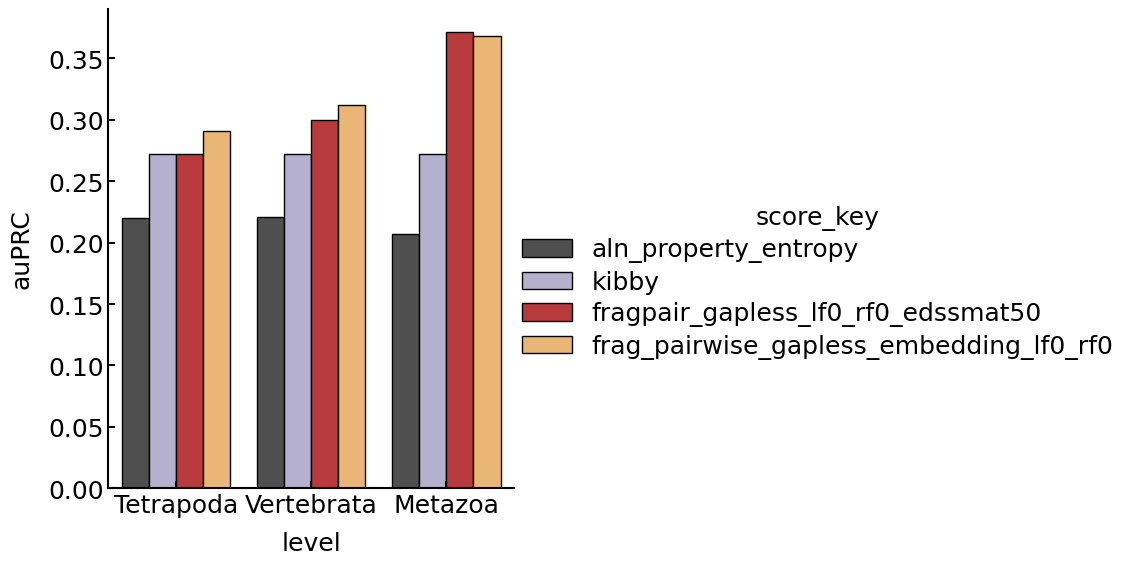

In [78]:
plot = sns.catplot(
    data=general_auprc_df[
        (general_auprc_df['rflank']!=5)
        & (general_auprc_df['reciprocal_best_match']!=True)
    ],
    y="auPRC",
    # hue='aln_type',
    hue='score_key',
    x='level',
    kind='bar',
    aspect=1.1,
    height=6,
    hue_order=[
        'aln_property_entropy',
        'kibby',
        'fragpair_gapless_lf0_rf0_edssmat50',
        'frag_pairwise_gapless_embedding_lf0_rf0',
        # 'fragpair_gapless_lf5_rf5_edssmat50',
        # 'frag_pairwise_gapless_embedding_lf5_rf5',
    ],
    # palette={'aln_property_entropy': '#4f4f4f', 'kibby': '#7f8585', 'fragpair_gapless_lf0_rf0_edssmat50': '#cc2529', 'frag_pairwise_gapless_embedding_lf0_rf0':'#fdb863'},
    palette={'aln_property_entropy': '#4f4f4f', 'kibby': '#b2abd2', 'fragpair_gapless_lf0_rf0_edssmat50': '#cc2529', 'frag_pairwise_gapless_embedding_lf0_rf0':'#fdb863'},
    # palette='viridis',
    # palette={'MSA - MAFFT': '#7f8585', 'Pairwise': '#cc2529'},#cc2529
)

In [80]:
classes = list(z_long['ELM_motif_class'].unique())
class_list, score_inds, auprc_list = [], [], []
scores = z_long['score_index'].unique()
for cl in classes:
    for c, i in enumerate(z_long['score_index'].unique()):
        df_filtered = z_long[z_long['score_index']==i]
        df_copy = df_filtered[df_filtered['ELM_motif_class'] == cl].copy()
        prc_results = tools.df_2_precision_recall_curve(df_copy, 'verified interaction', 'conservation_score')
        class_list.append(cl)
        score_inds.append(i)
        auprc_list.append(prc_results[3])
auprc_df = pd.DataFrame({'ELM_motif_class': class_list, 'score_index': score_inds, 'auPRC': auprc_list})
auprc_df = pd.merge(auprc_df, score_key2, on='score_index', how='left')

aln_df=auprc_df[auprc_df['aln_type']=='MSA - MAFFT'][["ELM_motif_class", "auPRC", "level"]].copy()
auprc_df_norm=pd.merge(auprc_df, aln_df, on=['ELM_motif_class', 'level'], how='left', suffixes=('', '_aln'))

auprc_df_norm["auPRC_diff"] = auprc_df_norm["auPRC"] - auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_increase"] = auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_log_increase"] = np.log10(
    auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
)
auprc_df_norm['ELM_motif_class'] = auprc_df_norm['ELM_motif_class'].replace('enah_LPPPP_FPPPP', 'Ena/VASP ([FL]PPPP)')
auprc_df_norm.tail(10)

,ELM_motif_class,score_index,auPRC,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing,auPRC_aln,auPRC_diff,auPRC_increase,auPRC_log_increase
182,TRAF6,43.0,0.403588,Pairwise,Metazoa,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2723,0.251941,0.151646,1.601911,0.204638
183,TRAF6,58.0,0.164998,Pairwise embedding,Tetrapoda,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2448,0.243391,-0.078393,0.677912,-0.168827
184,TRAF6,59.0,0.261964,Pairwise embedding,Tetrapoda,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2544,0.243391,0.018573,1.076308,0.031937
185,TRAF6,66.0,0.165449,Pairwise embedding,Vertebrata,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2605,0.193873,-0.028424,0.853387,-0.068854
186,TRAF6,67.0,0.272608,Pairwise embedding,Vertebrata,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2706,0.193873,0.078735,1.406114,0.148021
187,TRAF6,74.0,0.134313,Pairwise embedding,Metazoa,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2619,0.251941,-0.117628,0.533112,-0.273181
188,TRAF6,75.0,0.387188,Pairwise embedding,Metazoa,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2723,0.251941,0.135247,1.536818,0.186622
189,TRAF6,kibby_hit_zscores,0.029014,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby,0.251941,-0.222928,0.115160,-0.938697
190,TRAF6,kibby_hit_zscores,0.029014,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby,0.243391,-0.214378,0.119206,-0.923702
191,TRAF6,kibby_hit_zscores,0.029014,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby,0.193873,-0.164860,0.149653,-0.824915


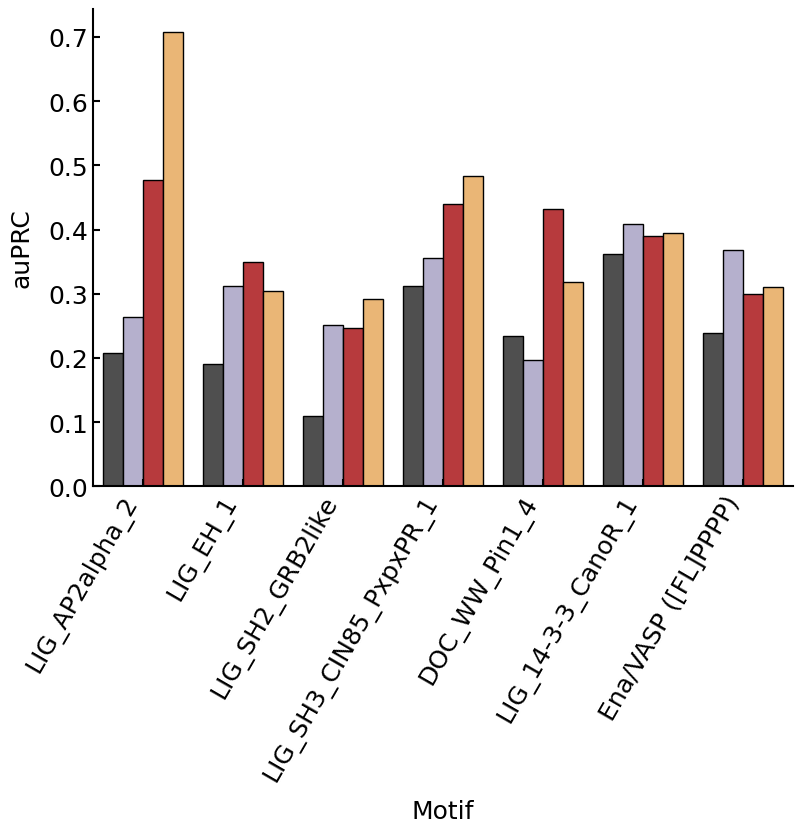

In [83]:
temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
temp = temp[(temp['level']=='Metazoa')&(temp['reciprocal_best_match'].isin([False, 'MSA', 'kibby']))].copy()
temp = temp[temp['rflank']!=5]
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_key",
    kind="bar",
    height=6,
    aspect=1.5,
    hue_order=[
        'aln_property_entropy',
        'kibby',
        'fragpair_gapless_lf0_rf0_edssmat50',
        'frag_pairwise_gapless_embedding_lf0_rf0',
    ],
    # col="lflank",
    # row='level',
    palette={'aln_property_entropy': '#4f4f4f', 'kibby': '#b2abd2', 'fragpair_gapless_lf0_rf0_edssmat50': '#cc2529', 'frag_pairwise_gapless_embedding_lf0_rf0':'#fdb863'},
    # palette={'aln_property_entropy': '#7f8585', 'kibby': '#4f4f4f', 'fragpair_gapless_lf0_rf0_edssmat50': '#cc2529', 'frag_pairwise_gapless_embedding_lf0_rf0':'#fdb863'},
    # ="reciprocal_best_match",
    # facet_kws=dict(margin_titles=True),
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
plot._legend.remove()
plot.set_xlabels('Motif')

# plt.tight_layout()
# plt.savefig('./benchmark_results.png', bbox_inches='tight', dpi=400)

In [ ]:
#e66101
#fdb863
#b2abd2
#5e3c99

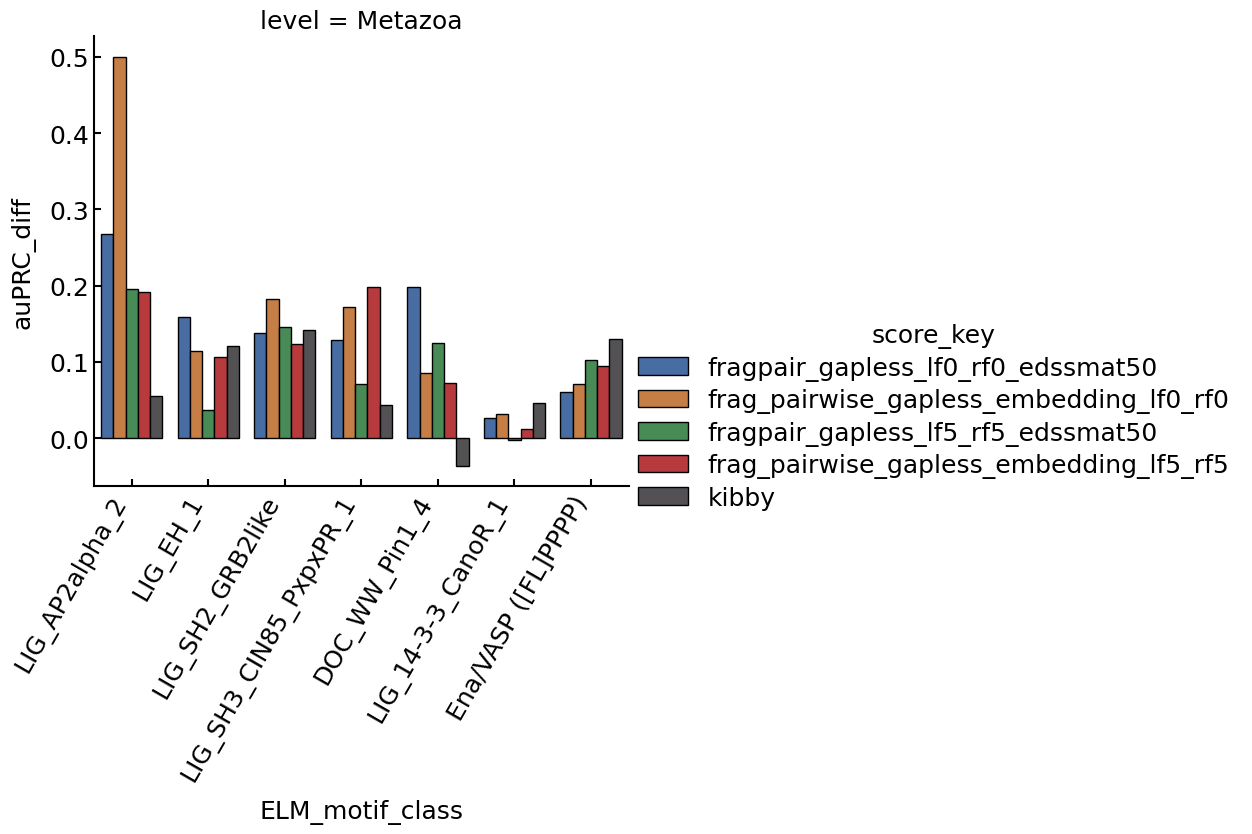

In [168]:
temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
plot = sns.catplot(
    data=temp[
        (temp['level']=='Metazoa')
        # & (temp['lflank'].isin(['MSA',0]))
        & (temp['reciprocal_best_match'].isin([False, 'kibby']))
    ],
    x="ELM_motif_class",
    y="auPRC_diff",
    hue="score_key",
    kind="bar",
    height=6,
    aspect=1.25,
    hue_order=[
        # 'aln_property_entropy',
        'fragpair_gapless_lf0_rf0_edssmat50',
        'frag_pairwise_gapless_embedding_lf0_rf0',
        'fragpair_gapless_lf5_rf5_edssmat50',
        'frag_pairwise_gapless_embedding_lf5_rf5',
        'kibby'
    ],
    # col="lflank",
    row='level',
    # palette={'MSA - MAFFT': '#7f8585', 'Pairwise': '#cc2529'},
    # ="reciprocal_best_match",
    # facet_kws=dict(margin_titles=True),
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot._legend.remove()
# plt.tight_layout()
# plt.savefig('./benchmark_results.png', bbox_inches='tight', dpi=400)

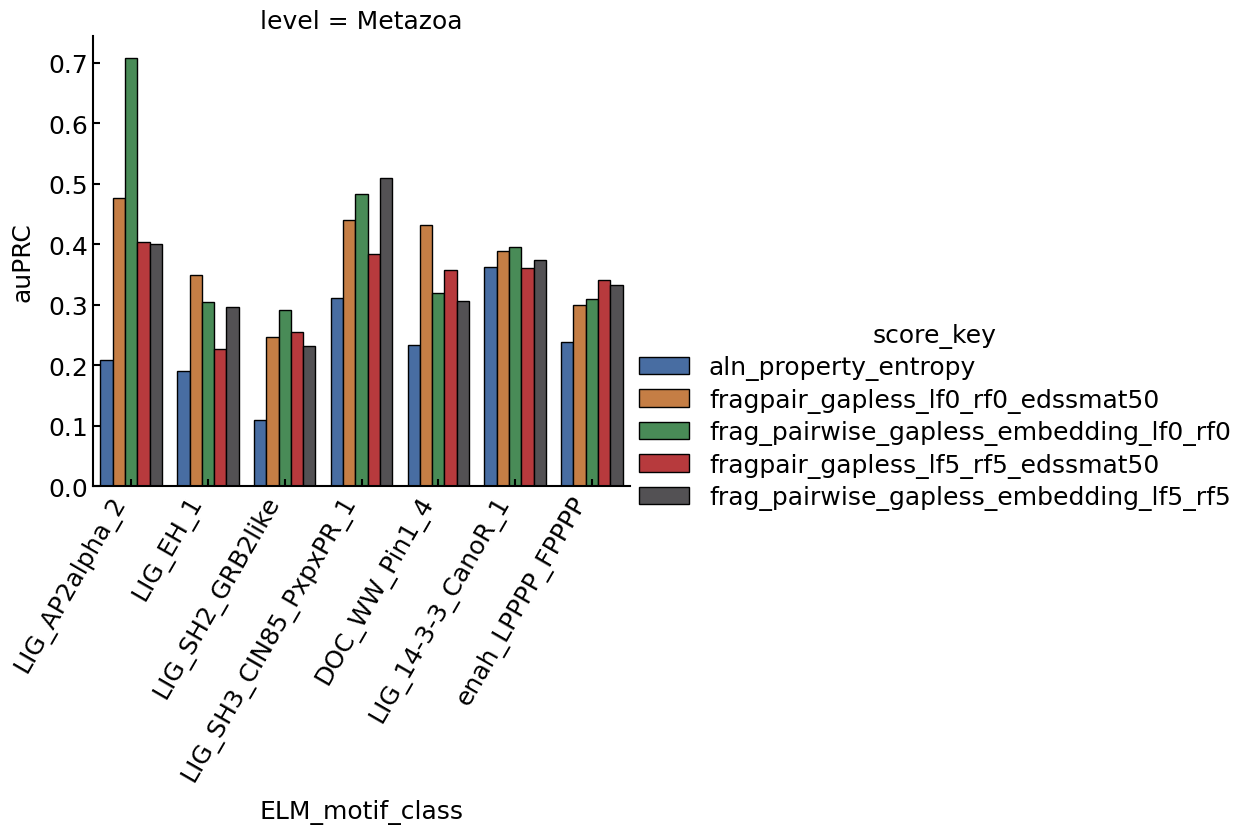

In [38]:
temp = auprc_df[auprc_df['ELM_motif_class']!='TRAF6']
plot = sns.catplot(
    data=temp[
        (temp['level']=='Metazoa')
        # & (temp['lflank'].isin(['MSA',0]))
        & (temp['reciprocal_best_match'].isin(['MSA',False]))
    ],
    x="ELM_motif_class",
    y="auPRC",
    hue="score_key",
    kind="bar",
    height=6,
    aspect=1.25,
    hue_order=[
        'aln_property_entropy',
        'fragpair_gapless_lf0_rf0_edssmat50',
        'frag_pairwise_gapless_embedding_lf0_rf0',
        'fragpair_gapless_lf5_rf5_edssmat50',
        'frag_pairwise_gapless_embedding_lf5_rf5',
    ],
    # col="lflank",
    row='level',
    # palette={'MSA - MAFFT': '#7f8585', 'Pairwise': '#cc2529'},
    # ="reciprocal_best_match",
    # facet_kws=dict(margin_titles=True),
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot._legend.remove()
# plt.tight_layout()
# plt.savefig('./benchmark_results.png', bbox_inches='tight', dpi=400)

In [40]:
classes = list(z_long['ELM_motif_class'].unique())
class_list, score_inds, ave_prec_list = [], [], []
scores = z_long['score_index'].unique()
for cl in classes:
    # fig, ax = plt.subplots(ncols=len(scores), figsize=(5*len(scores), 5))
    for c, i in enumerate(z_long['score_index'].unique()):
        df_filtered = z_long[z_long['score_index']==i]
        df_copy = df_filtered[df_filtered['ELM_motif_class'] == cl].copy()
        ave_prec = tools.df_2_ave_precision(df_copy, 'verified interaction', 'conservation_score')
        # ax[c] = plot_precision_recall_curve(prc_results[0], prc_results[1], ax=ax[c])
        # ax[c].set_title(f'{cl}\n{get_title(score_index_table, i)} \nAUPRC: {prc_results[3]:.3f}', fontsize=8)
        class_list.append(cl)
        score_inds.append(i)
        ave_prec_list.append(ave_prec)
    # fig.tight_layout()
ave_pre_df = pd.DataFrame({'ELM_motif_class': class_list, 'score_index': score_inds, 'ave_prec': ave_prec_list})
ave_pre_df = pd.merge(ave_pre_df, score_key, on='score_index', how='left')

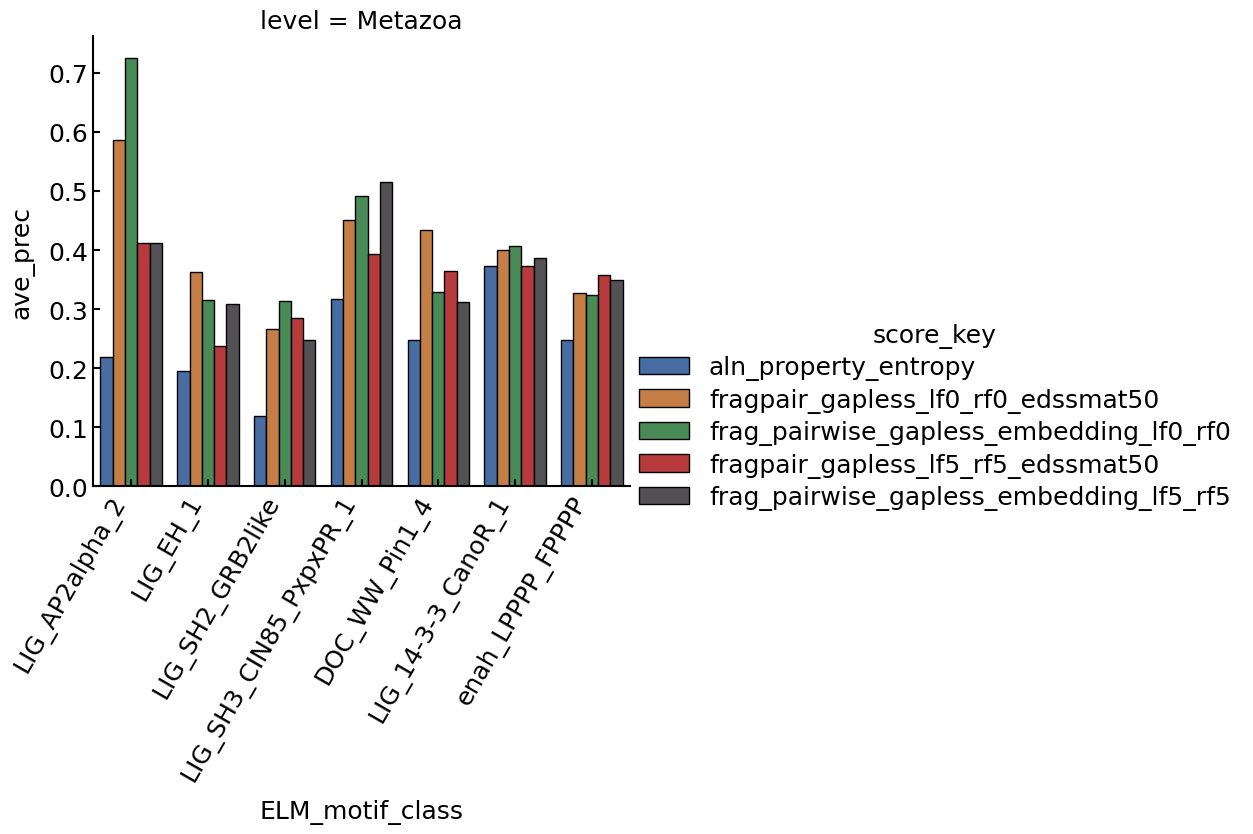

In [42]:
temp = ave_pre_df[ave_pre_df['ELM_motif_class']!='TRAF6']
plot = sns.catplot(
    data=temp[
        (temp['level']=='Metazoa')
        # & (temp['lflank'].isin(['MSA',0]))
        & (temp['reciprocal_best_match'].isin(['MSA',False]))
    ],
    x="ELM_motif_class",
    y="ave_prec",
    hue="score_key",
    kind="bar",
    height=6,
    aspect=1.25,
    hue_order=[
        'aln_property_entropy',
        'fragpair_gapless_lf0_rf0_edssmat50',
        'frag_pairwise_gapless_embedding_lf0_rf0',
        'fragpair_gapless_lf5_rf5_edssmat50',
        'frag_pairwise_gapless_embedding_lf5_rf5',
    ],
    # col="lflank",
    row='level',
    # palette={'MSA - MAFFT': '#7f8585', 'Pairwise': '#cc2529'},
    # facet_kws=dict(margin_titles=True),
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot._legend.remove()
# plt.tight_layout()
# plt.savefig('./benchmark_results.png', bbox_inches='tight', dpi=400)

In [58]:
score_keys=score_key_filt['score_index'].unique()
score_key_filt[score_key_filt['score_index'].isin(score_keys)].set_index('score_index')['table_file'].to_dict()

{0.0: '/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_scores_v3/0.csv',
 2.0: '/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_scores_v3/2.csv',
 4.0: '/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_scores_v3/4.csv',
 10.0: '/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_scores_v3/10.csv',
 11.0: '/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_scores_v3/11.csv',
 14.0: '/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_scores_v3/14.csv',
 15.0: '/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_scores_v3/15.csv',
 21.0: '/home/jch/Documents/07-pt1_pt2_combined/benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_s

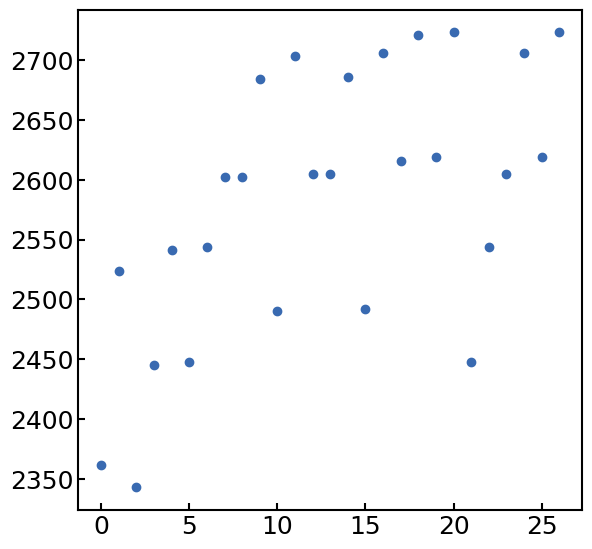

In [45]:
x = list(range(len(score_key_filt)))
y = score_key_filt['num_passing']
fig, ax = plt.subplots()
ax.plot(x, y, 'o')

In [59]:
# pd.read_csv(score_key.loc[0, 'table_file'])['hit_scores'].str.contains('nan').sum()
pd.read_csv(score_key.loc[0, 'table_file'])['hit_z_scores'].isna().sum()
pd.read_csv(score_key.loc[50, 'table_file'])['hit_z_scores'].isna().sum()
pd.read_csv(score_key.loc[6, 'table_file'])['hit_z_scores'].isna().sum()
pd.read_csv(score_key.loc[6, 'table_file'])[pd.read_csv(score_key.loc[6, 'table_file'])['hit_z_scores'].isna()][['hit_z_scores', 'hit_scores', 'n_bg_scores', 'bg_STD', 'bg_mean', 'errors']]
# pd.read_csv(score_key.loc[50, 'table_file'])['hit_z_scores'].str.contains('nan').sum()
# pd.read_csv(score_key.loc[0, 'table_file']).columns

,hit_z_scores,hit_scores,n_bg_scores,bg_STD,bg_mean,errors
47,NaN,"[0.1935843884857762, 0.3255844424596454, 0.219...",NaN,NaN,NaN,not enough background scores to calculate z-score
48,NaN,"[0.16397324020045215, 0.24759214279618758, 0.1...",NaN,NaN,NaN,not enough background scores to calculate z-score
55,NaN,"[0.8057897922692016, 0.5221706006708329, 0.936...",NaN,NaN,NaN,not enough background scores to calculate z-score
60,NaN,"[0.17532457927627698, 0.16353185487717384, 0.1...",NaN,NaN,NaN,not enough background scores to calculate z-score
63,NaN,"[0.24388122580535856, 0.3032450720325047, 0.39...",NaN,NaN,NaN,not enough background scores to calculate z-score
...,...,...,...,...,...,...
2846,NaN,"[0.2161935355007797, 0.3158029326324182, 0.158...",NaN,NaN,NaN,not enough background scores to calculate z-score
2847,NaN,"[0.16211035880560185, 0.21735878785901558, 0.1...",NaN,NaN,NaN,not enough background scores to calculate z-score
2848,NaN,"[0.15790064940436493, 0.2541090438485286, 0.17...",NaN,NaN,NaN,not enough background scores to calculate z-score
2855,NaN,"[0.26741769134450855, 0.1588738028783412, 0.17...",NaN,NaN,NaN,not enough background scores to calculate z-score


In [ ]:
# temp = score_key.loc[score_key['score_key'].isin(colmap.keys())]
# score_key.loc[score_key['score_key'].isin(colmap.keys()), 'columnwise_score_function_name'] = temp['score_key'].map(colmap)